## install and import all required packages

In [1]:
!pip install mapie

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 KB 3.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the data and split it into training and testing sets

### 1st dataset

In [9]:
df = pd.read_csv('drive/MyDrive/Test_Data_CSV.csv')
df.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.9
1,1,0.361690,54.986671,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.8
2,1,0.000000,55.424786,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.7
3,1,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
4,1,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5


In [49]:
len(df)

39414

In [12]:
X = df[df.columns[1 : -2]]
y = df["RUL"]

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test   = train_test_split(X, y, test_size=0.1)


In [118]:
print(len(X_train))
print(len(X_test))

35472
3942


### 2nd dataset

In [29]:
df_2 = pd.read_csv('drive/MyDrive/Second_dataset_rul.csv')
len(df_2)

166441

In [5]:
df_2.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,rul
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,285.916667
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,285.900000
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,285.883333
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,285.866667
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,285.850000


In [38]:
df_2 = df_2[0:5000]

In [39]:
df_2['timestamp'] = pd.to_datetime(df_2['timestamp']).values.astype(float)

In [58]:
X_2 = df_2[df_2.columns[2 : -1]]
y_2 = df_2["rul"]

In [59]:
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2   = train_test_split(X_2, y_2, test_size=0.1)

## Models and conformal predictions

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

def random_forest(X_train, y_train, X_test):
  regr = RandomForestRegressor(max_depth=2, random_state=0)
  model = regr.fit(X_train, y_train)

  Y_pred = regr.predict(X_test)

  return model

In [55]:
from sklearn.svm import SVR
def svr(X_train, y_train, X_test):
  svr = SVR().fit(X_train, y_train)
  yfit = svr.predict(X_test)
  return svr


In [17]:
from mapie.regression import MapieRegressor

def conformal_prediction(model, a, X_train, y_train, X_test):
  mapie = MapieRegressor(estimator=model)
  mapie_reg = mapie.fit(X_train, y_train)
  y_pred, y_pis = mapie_reg.predict(X_test, alpha=a)

  return y_pred, y_pis

## Plotting functions

In [48]:
import matplotlib.pyplot as plt

def plot_without_cp(y_test, y_pred):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x[0:100],y_pred[0:100])
  plt.plot(x[0:100],y_test[0:100])
  plt.xlabel('First 100th sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of first 100 samples')
  plt.legend(["prediction","true"])
  plt.grid(True)
  plt.show()

In [49]:
def plot_with_cp(y_test, y_pred, y_pis, confidence):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x[0:100],y_pred[0:100])
  plt.plot(x[0:100],y_test[0:100])

  #plt.plot(x[0:100],y_pis[:,0][0:100])
  #plt.plot(x[0:100],y_pis[:,1][0:100])

  plt.fill_between(x[0:100], y_pis[:,0][0:100].flatten(), y_pis[:,1][0:100].flatten(), alpha=0.2, color='tab:green')

  plt.xlabel('First 100 sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of first 100th samples with confidence of ' + confidence +'%')
  plt.legend(["prediction","true",confidence + "% confidence interval"])
  plt.grid(True)
  plt.show()

## Random forest

### 1st dataset

In [123]:
rf_model = random_forest(X_train, y_train, X_test)

In [132]:
y_pred_rf, y_pis_rf = conformal_prediction(rf_model,0.1, X_train, y_train, X_test)

In [133]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_rf)

0.7691341804398413

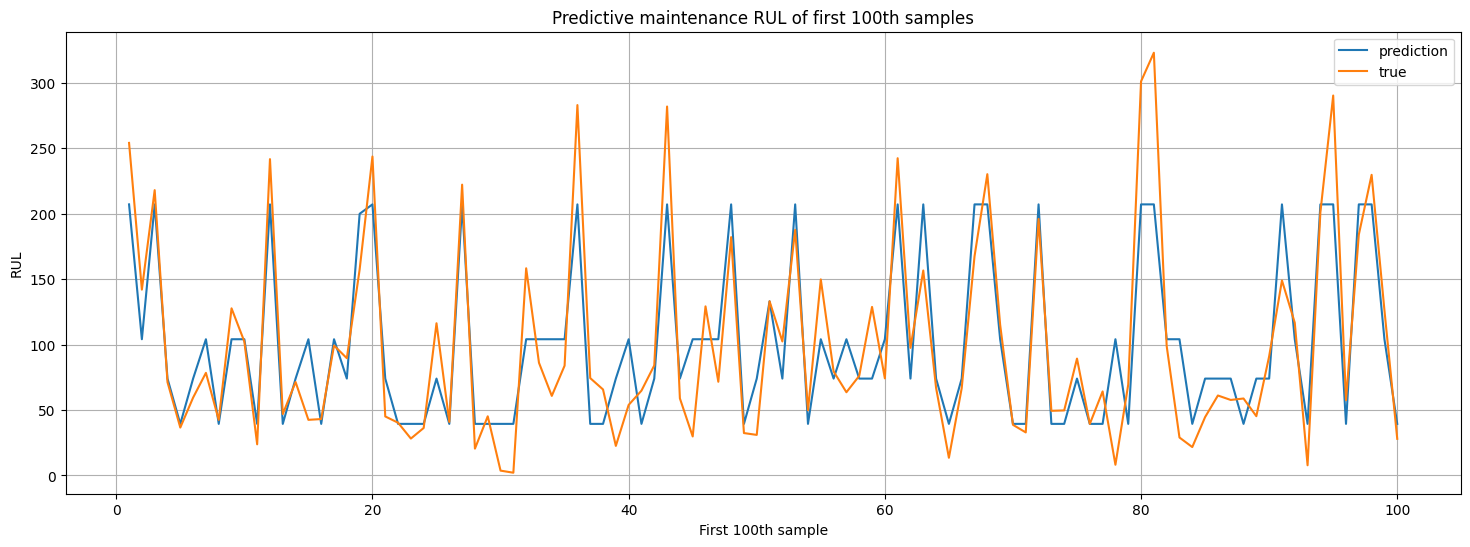

In [137]:
plot_without_cp(y_test, y_pred_rf)

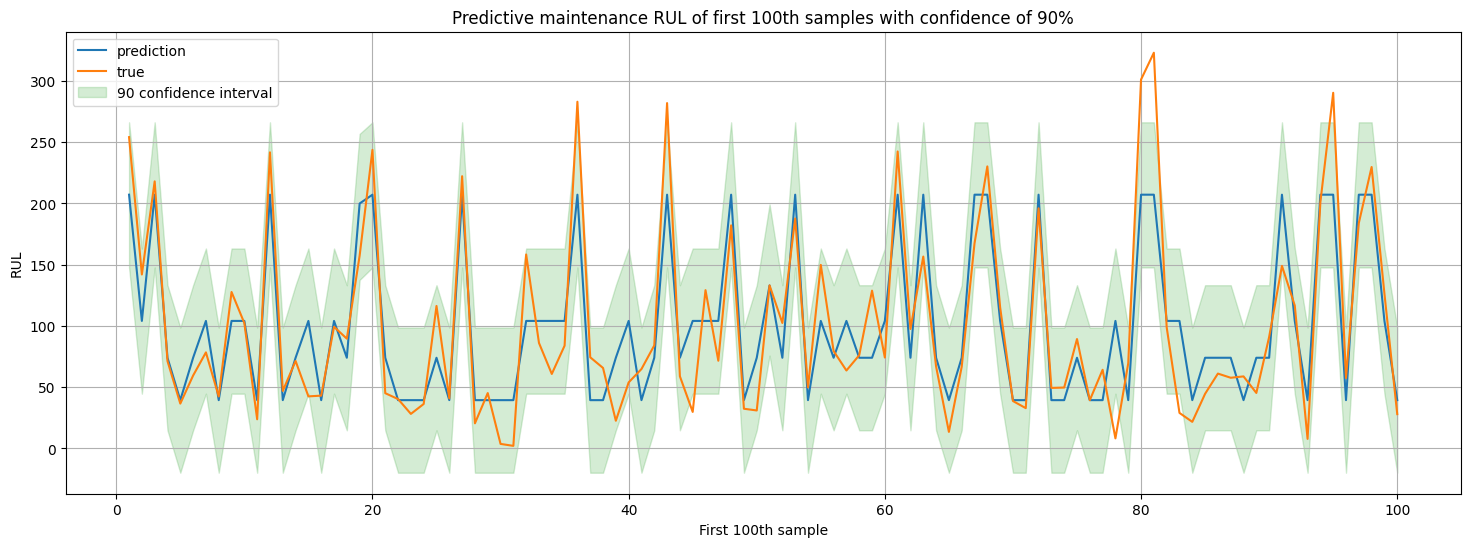

In [139]:
plot_with_cp(y_test, y_pred_rf, y_pis_rf, "90")

### 2nd dataset

In [42]:
rf_model_2 = random_forest(X_train_2, y_train_2, X_test_2)

In [46]:
y_pred_rf_2, y_pis_rf_2 = conformal_prediction(rf_model_2,0.1, X_train_2, y_train_2, X_test_2)

In [47]:
from sklearn.metrics import r2_score
r2_score(y_test_2, y_pred_rf_2)

0.9465858015217452

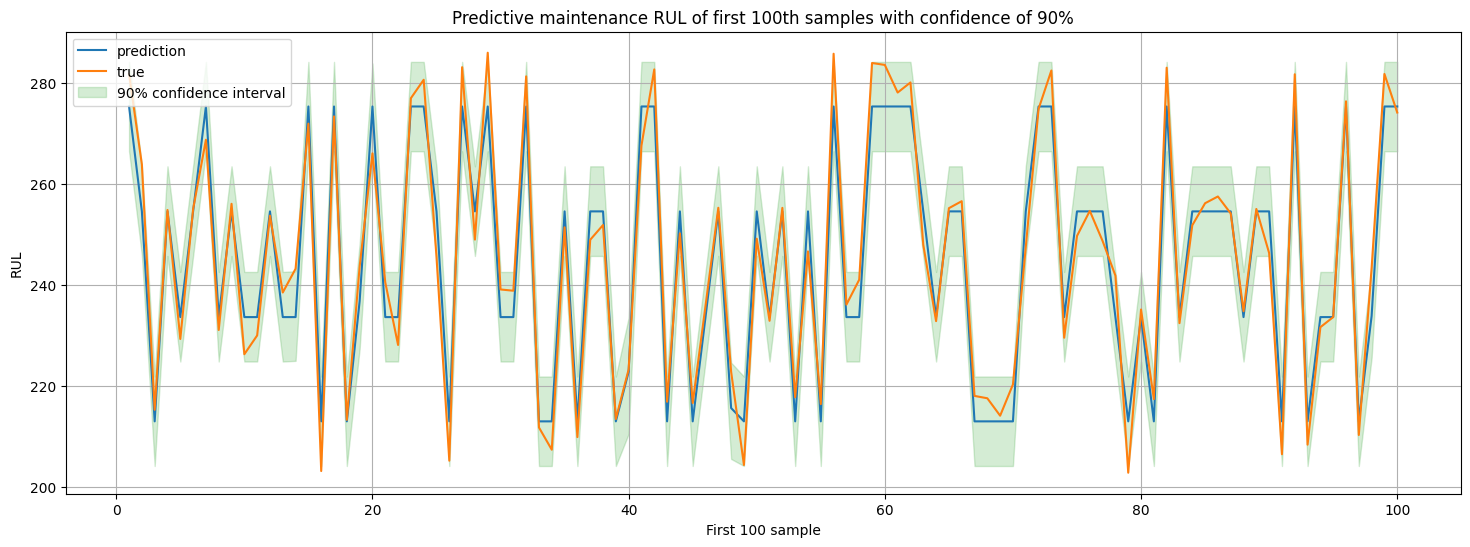

In [50]:
plot_with_cp(y_test_2, y_pred_rf_2, y_pis_rf_2, "90")

## SVR

### 1st dataset

In [142]:
svr_model = svr(X_train, y_train, X_test)

In [143]:
y_pred_svr, y_pis_svr = conformal_prediction(svr_model,0.1,X_train, y_train, X_test)

In [144]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_svr)

0.9502598549227307

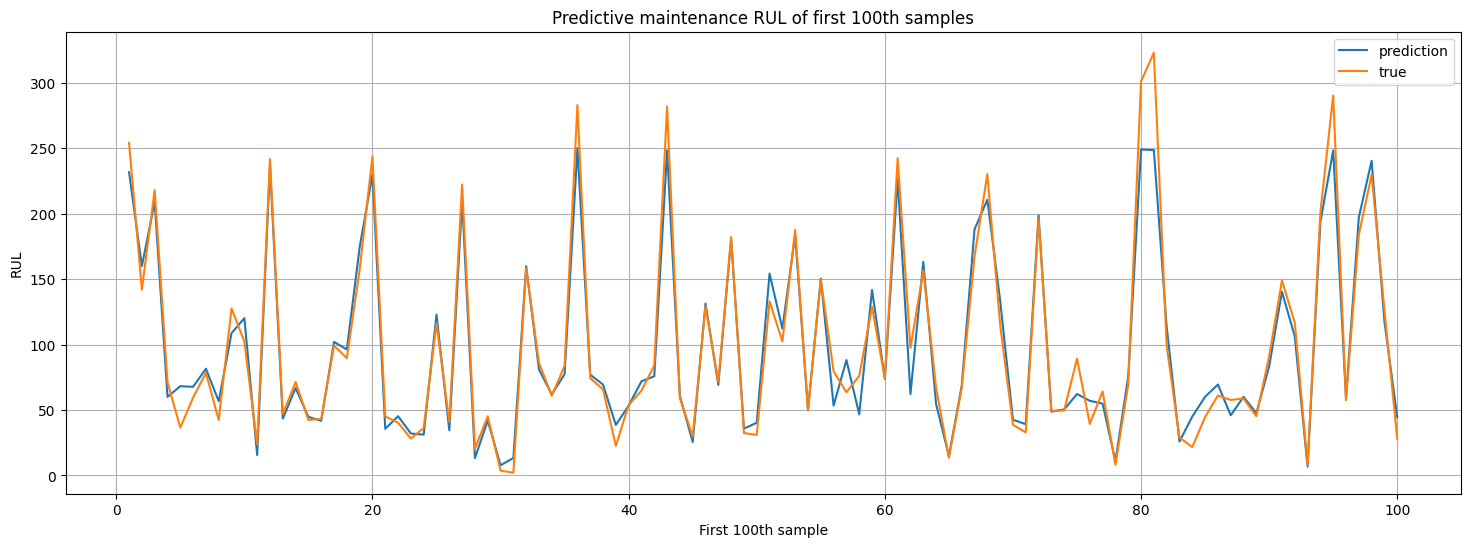

In [145]:
plot_without_cp(y_test, y_pred_svr)

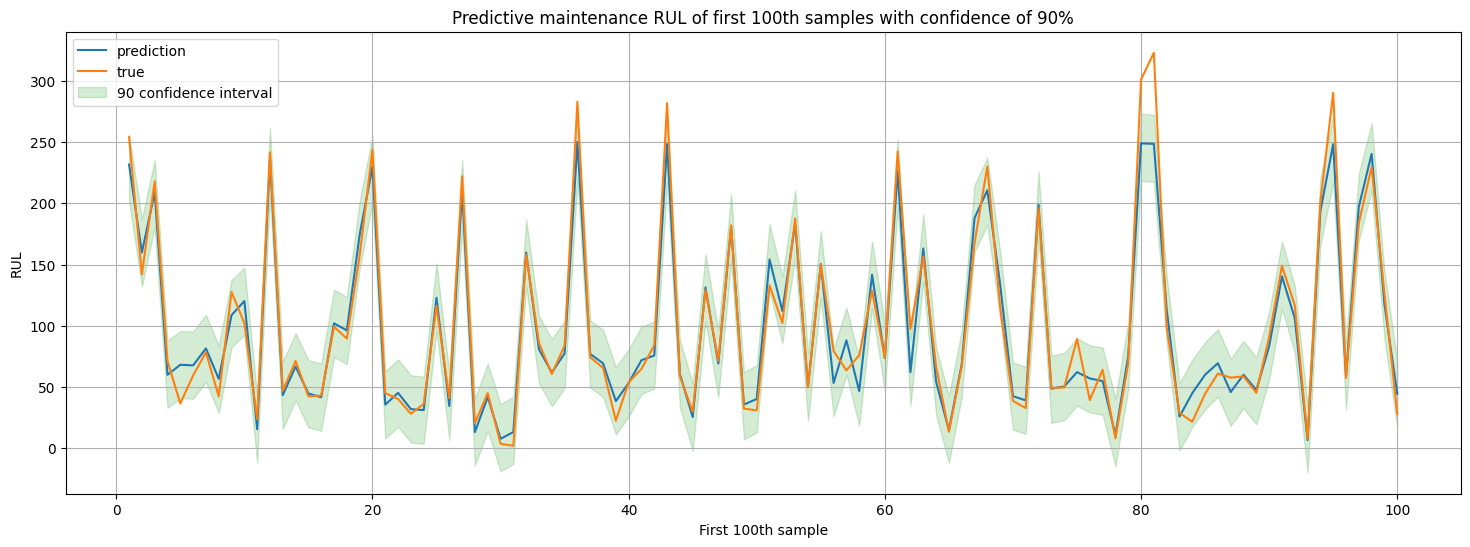

In [146]:
plot_with_cp(y_test, y_pred_svr, y_pis_svr, "90")

### 2nd dataset

In [60]:
svr_model_2 = svr(X_train_2, y_train_2, X_test_2)

In [62]:
y_pred_svr_2, y_pis_svr_2 = conformal_prediction(svr_model_2,0.1,X_train_2, y_train_2, X_test_2)

In [63]:
from sklearn.metrics import r2_score
r2_score(y_test_2, y_pred_svr_2)

0.6698897759166256

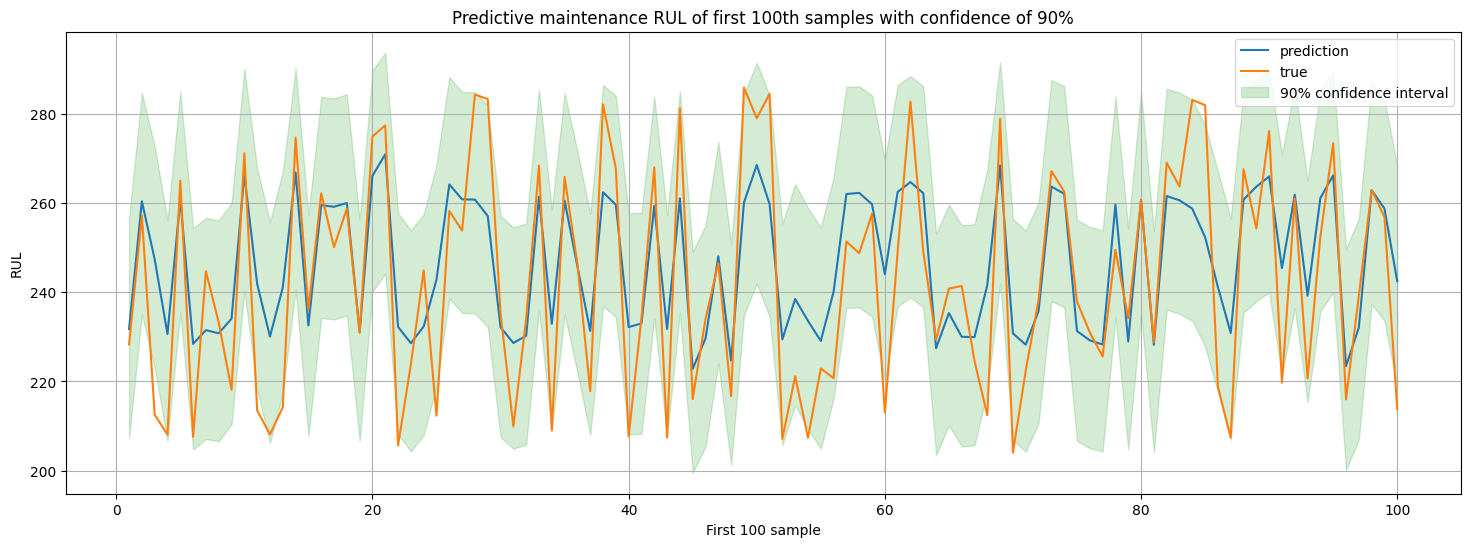

In [64]:
plot_with_cp(y_test_2, y_pred_svr_2, y_pis_svr_2, "90")